# Assignment 2
Some general remarks for handing in exercises:
- Each exercise comes with context and code from the exercise-set of which it is a part. It is up to you to recycle the right code. Run all the code (make sure the output is present and correct as far as you can tell) and then save and submit.  Submitting code without running it runs the risk of not getting credit.
- Make sure to answer each sub-exercise
- Commenting amply on your results makes it easier to understand that you were on the right track, even if the answer was incorrect (or partially correct)

In [1]:
import re, os
from matplotlib import pyplot as plt


def get_alliances(char, faction=None):
    """Return list of alliances for Marvel character.
    
    Input
    -----
        char : str
            A valid character name of any faction
        faction : str
            Either 'heroes', 'villains', 'ambiguous' or None. If None, the function
            looks through the respective faction folders to figure out which faction
            `char` belongs to. The function is therefore FASTER if `faction` is provided
    
    Output
    ------
        out : list of strings
            List of alliance names
    """
    
    # If faction is not provided, figure out which faction it is by looping through
    # folders of character names
    if faction is None:
        for faction in ["heroes", "villains", "ambiguous"]:
            if char + ".txt" in os.listdir("../data/%s" % faction):
                break
    
    # Load character markup
    with open("../data/%s/%s.txt" % (faction, char)) as fp:
         markup = fp.read()

    # Get alliance field
    alliances_field = re.findall(r"\| *alliances[\w\W]+?(?=\|.+=|\}\})", markup)
    if alliances_field == []:
        return []

    # Extract teams from alliance field
    return [
        t[2:-1]
        for t in re.findall(r"\[\[.+?[\]\|\#]", alliances_field[0][10:])
        if not 'List of' in t
    ]


def alliance_vector(character_name, alliances_sorted):
    character_alliances = set(get_alliances(character_name))
    return [(1 if alliance in character_alliances else 0) for alliance in alliances_sorted]

def evaluate(predictions, actuals, match_val):
    correct_guesses = sum(int(prediction == actual) for (prediction, actual) in zip(predictions, actuals))
    accuracy = correct_guesses / len(predictions)
    min_fac = Counter(target_matrix_no_ambiguous).most_common()[-1][0]
    tp = sum(int(prediction == match_val and actual == match_val) for (prediction, actual) in zip(predictions, actuals))
    fp = sum(int(prediction == match_val and actual != match_val) for (prediction, actual) in zip(predictions, actuals))
    tn = sum(int(prediction != match_val and actual != match_val) for (prediction, actual) in zip(predictions, actuals))
    fn = sum(int(prediction != match_val and actual == match_val) for (prediction, actual) in zip(predictions, actuals))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall) 
    return (accuracy, precision, recall, f1)

factions = ('villains', 'heroes', 'ambiguous')
characters = sorted([character[:-4] for faction in factions for character in os.listdir("../data/%s" % faction)])
all_teams_set = {alliance for character in characters for alliance in get_alliances(character)}
all_teams = sorted(list(all_teams_set))

In [2]:
# 4.1.4.1
characters_with_alliances = sorted([character for character in characters if sum(alliance_vector(character, all_teams)) > 0])
feature_matrix = [alliance_vector(character, all_teams) for character in characters_with_alliances]
targets = [(character[:-4], faction) for faction in range(len(factions)) for character in os.listdir("../data/%s" % factions[faction])]
target_matrix = [target[1] for target in sorted(targets) if target[0] in set(characters_with_alliances)]

In [3]:
# remove ambiguous characters (with alliances) from our dataframe:
ambiguous = {character[:-4] for character in os.listdir('../data/ambiguous')}
# make new feature and target matrices without rows to represent ambiguous characters
feature_matrix_no_ambiguous = [feature for (feature, name) in zip(feature_matrix, characters_with_alliances) if name not in ambiguous]
target_matrix_no_ambiguous = [faction for (faction, name) in zip(target_matrix, characters_with_alliances) if name not in ambiguous]
characters_no_ambiguous = [name for name in characters_with_alliances if name not in ambiguous]

### Week 4

> **Ex. 4.3.1**: Investigate how well your model generalizes. You may have noticed that the performance seemed a little too good to be true in Ex 4.2.1.
1. Why did you get such a high accuracy in the previous exercise?
2. Split your data into a test and training set of equal size. Train the model only on the training set and report its accuracy and F1 score (for minority class) on both the training and test sets.
3. Comment on the difference you observe.
>
> *Hint: Watch out for unbalanced class proportions! You may want to randomly reorder the rows of your datapoints and target labels so your training and test sets have the same amount of heroes and villains.*

4.3.1.1: Our high accuracy can be explainined by our model training on the same dataset that we tested it on. To evaluate our model fairly, we must test it on data that it hasn't seen yet (ie data that it didn't train on)

In [4]:
# 4.3.1.2:
from sklearn.naive_bayes import BernoulliNB
from collections import Counter

#model = BernoulliNB()


n = len(feature_matrix_no_ambiguous) // 2
training_features = feature_matrix_no_ambiguous[:n]
test_features = feature_matrix_no_ambiguous[n:]
training_targets = target_matrix_no_ambiguous[:n]
test_targets = target_matrix_no_ambiguous[n:]

split_model = BernoulliNB()
split_model.fit(training_features, training_targets)

split_model_predictions = split_model.predict(test_features)
min_fac = Counter(target_matrix_no_ambiguous).most_common()[-1][0]
(accuracy, precision, recall, f1) = evaluate(split_model_predictions, test_targets, min_fac) 
message = f"""
Our model predicts the minority faction with:
accuracy   {accuracy}
F1         {f1}
"""
print(message)


Our model predicts the minority faction with:
accuracy   0.8256578947368421
F1         0.7836734693877551



4.3.1.3: Our model predicts factions quite well even when it is only trained with half of the dataset. This tells us that our dataset is quite clustered. ie A portion of our dataset is representative of our dataset as a whole

>**Ex. 4.4.1**: Let's put our classifier to use!
* Retrain your model on all of your data (still only heroes and villains).
* Get a team alliance representation of the ambiguous characters
* Use the model the estimate the probability that each character is a villain (let's call this *villainness*). You can use the `.predict_proba` method on the model to get probability estimates rather than class assignments. It produces an array with two columns, where the 1st column is the probability of class 1 (which is heroes).
* **Visualize the "heroness" distribution for all ambiguous characters**. Comment on the result.

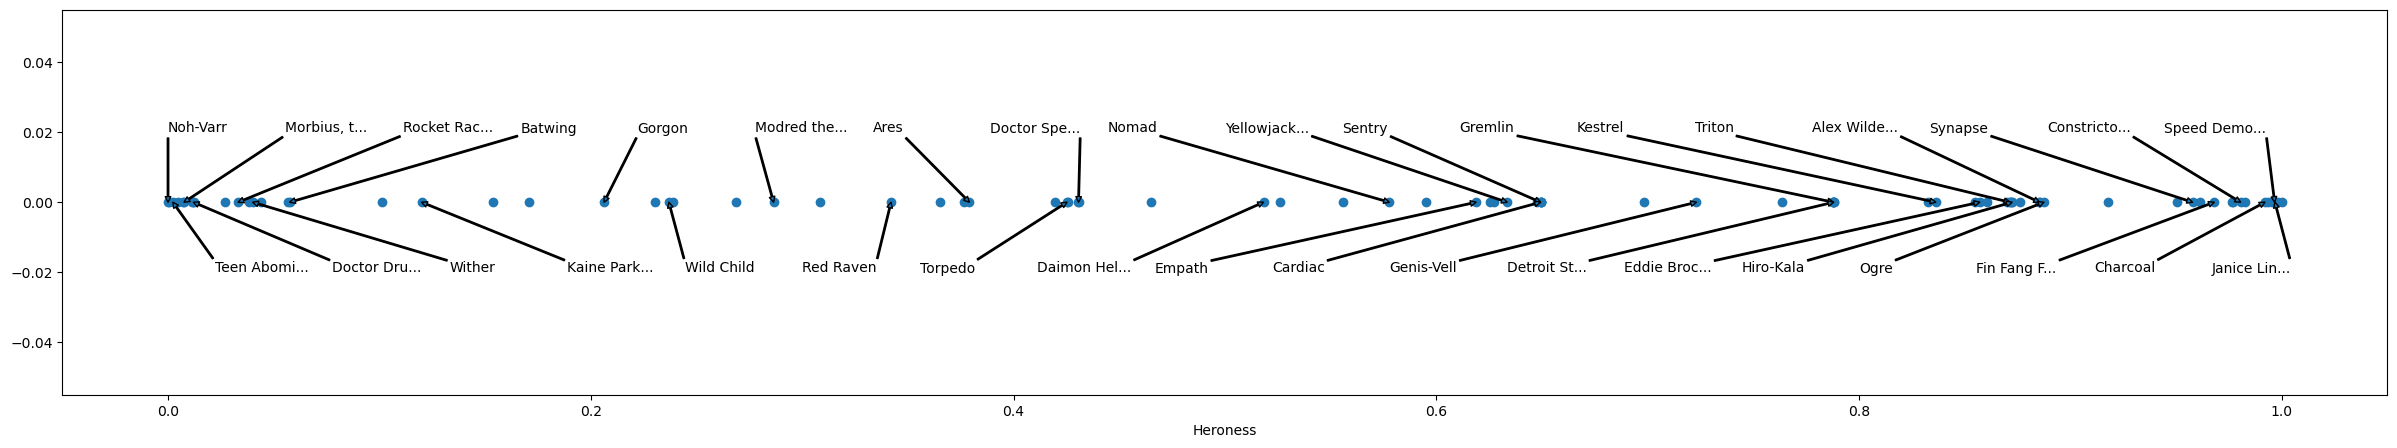

In [5]:
import numpy
model = BernoulliNB()
model.fit(feature_matrix_no_ambiguous, target_matrix_no_ambiguous) 
# get the portion of the feature matrix for the ambiguous characters:
feature_matrix_ambiguous = [feature for (feature, faction) in zip(feature_matrix, target_matrix) if faction == 2]
# get the names of the ambiguous characters:
names_ambiguous = [name for (name, faction) in zip(characters_with_alliances, target_matrix) if faction == 2]
# get the names of the ambiguous characters:
heroness_ambiguous = [heroness for [heroness, villainness] in model.predict_proba(feature_matrix_ambiguous)]
plot_data = sorted(zip(heroness_ambiguous, names_ambiguous))
plt.figure(figsize=(30,5))
plt.scatter([x[0] for x in plot_data], numpy.zeros_like(heroness_ambiguous))
plt.xlabel('Heroness')
arrow_props = {
    'width': 1,
    'headwidth': 4,
    'headlength': 4,
    'shrink': 600
}
n = len(plot_data)
label_length = 10
stride = 5
# add lables on top of the graph
for i in range(0, len(plot_data), stride):
    cleaned_name = re.sub(r" \(.+\)", "", plot_data[i][1])
    txt = cleaned_name[:label_length] + ('...' if len(cleaned_name) > label_length else '')
    plt.annotate(text=txt, xy=(plot_data[i][0], 0), xytext=(i * plot_data[-1][0]/n, 0.02), arrowprops=arrow_props)
# add labels underneath the graph
for i in range(stride//2, len(plot_data), stride):
    cleaned_name = re.sub(r" \(.+\)", "", plot_data[i][1])
    txt = cleaned_name[:label_length] + ('...' if len(cleaned_name) > label_length else '')
    plt.annotate(text=txt, xy=(plot_data[i][0], 0), xytext=(i * plot_data[-1][0]/n, -0.02), arrowprops=arrow_props)
plt.show()

In [6]:
avg_heroness = sum(heroness_ambiguous) / len(heroness_ambiguous)
print(f'We find the average heroness for ambiguous characters to be {avg_heroness}')

We find the average heroness for ambiguous characters to be 0.5572821857982937


We notice a significant clustering on either end of the hero/villain spectrum. There seem to be a lot of ambiguous characters that are either really good or really bad (and not so many in between). These findings make sense intuitively to anyone who is familiar with the Marvel Comic Universe and its characters.

Furthermore, we find that the average heroness/villainess is slightly skewed toward heroness.

### Week 5
You should have a dataframe called `data_teams` with characters as rows and alliances as columns (+ one column for faction)

>**Ex. 5.1.2**: Split your data (`data_teams`) into two subsets. One where characters are affiliated with X-men and one where they are not.
1. What is the entropy of target labels in each subset?
2. What is the weighted average entropy of the split?
3. Write a function that computes the weighted average entropy of a split, given the data and team (name or id) on which to split the data. Show that it gives you the same split entropy that you obtained in point 2.
4. Plot the distribution of split entropy for all features. Comment on the result. My figure looks [like this](https://dhsvendsen.github.io/images/BD_5_1_2_4.png).

In [7]:
import pandas as pd
df= pd.read_csv('../outputs/marvel_characters.csv')
df

,Unnamed: 0,#Fearsome Four,1991 in comics,2013 in comics,A-Force,A-Next,A.I. Army,A.R.M.O.R.,Acolytes (comics),Action Pack (comics),...,Xavier Institute student body,Xavier's Security Enforcers,Yakuza,Young Allies,Young Allies (Marvel Comics),Young Avengers,Young Masters,Young X-Men,Zodiac (comics),faction
0,Abner Jenkins,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,Abomination (character),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Abraham Cornelius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Absorbing Man,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adam Warlock,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,Yellowjacket (Marvel Comics),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
693,Yo-Yo Rodriguez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
694,Zeke Stane,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
695,Zheng Zu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# shannon entropy is entropy log base 2 tells you your likelihood of randomness of a variable, if close to 0 then number is not very random
import math
def shannon(prob_vec):
    return -sum(0 if prob == 0 else prob * math.log(prob, 2) for prob in prob_vec)

In [9]:
# 5.1.2.1
xman = df.loc[(df['X-Men'] == 1)]
non_xman = df.loc[(df['X-Men'] != 1)]
# get the proportion of each faction in the xman dataframe
xman_prob_vec = [len(xman.loc[(xman['faction'] == faction)]) / len(xman) for faction in range(0, 3)]
non_xman_prob_vec = [len(non_xman.loc[(non_xman['faction'] == faction)]) / len(non_xman) for faction in range(0, 3)]
f'The X-Men have a shannon entropy of {shannon(xman_prob_vec)} and the non-X-Men have a shannon_entropy of {shannon(non_xman_prob_vec)}'

'The X-Men have a shannon entropy of 1.2189514568588302 and the non-X-Men have a shannon_entropy of 1.4113733977368847'

In [10]:
# 5.1.2.2
weighted_average_across_xman_split = ((shannon(xman_prob_vec) * len(xman)) + (shannon(non_xman_prob_vec) * len(non_xman))) / (len(xman) + len(non_xman))
weighted_average_across_xman_split

1.4025391048988678

In [11]:
# 5.1.2.3
def avg_weighted_shannon_across_split(df, split, entropy_feature, possible_entropy_feature_values):
    a = df.loc[(df[split] == 1)]
    b = df.loc[(df[split] != 1)]
    if (len(a) == 0 or len(b) == 0):
        print(split)
    a_vec = [len(a.loc[(a[entropy_feature] == feat)]) / len(a) for feat in possible_entropy_feature_values]
    b_vec = [len(b.loc[(b[entropy_feature] == feat)]) / len(b) for feat in possible_entropy_feature_values]
    try:
        return ((shannon(a_vec) * len(a)) + (shannon(b_vec) * len(b))) / (len(a) + len(b))
    except:
        print(f'{a_vec} {b_vec} {split}')

avg_weighted_shannon_across_split(df, 'X-Men', 'faction', range(0, 3))

1.4025391048988678

(array([  2.,   1.,   1.,   1.,   2.,   6.,   8.,  24.,  80., 309.]),
 array([1.37670094, 1.38147561, 1.38625027, 1.39102493, 1.3957996 ,
        1.40057426, 1.40534893, 1.41012359, 1.41489826, 1.41967292,
        1.42444758]),
 <BarContainer object of 10 artists>)

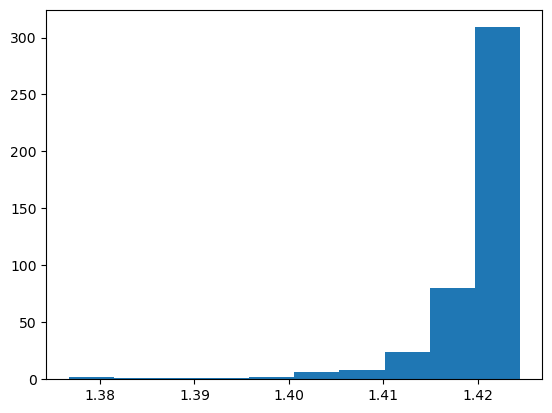

In [12]:
# 5.1.2.4
split_entropies = [avg_weighted_shannon_across_split(df, col, 'faction', range(0, 3)) for col in df.columns.values[1:-1]]
plt.hist(split_entropies)

This is a very clustered distribution. Most splits fall in a very narrow range of entropy. Most splits also are in the largest entropy tranche (about 1.42).

>**Ex. 5.2.2**: *Fit* a logistic regression! You can use the `scipy` module `scipy.optimize.curve_fit`
to fit a model to some data (i.e. find the best parameter values `w`). 
> Fit the `logistic_regression` to the data `x` (input) and `y` (target).
> Again, plot and color the points according to their prediction. My figure looks like [this](https://dhsvendsen.github.io/images/BD_5_2_2_b.png). Comment on the figure and on the shape of the decision boundary.

C:\Users\alexm\AppData\Local\Temp\ipykernel_33868\4124349356.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-lin_reg))


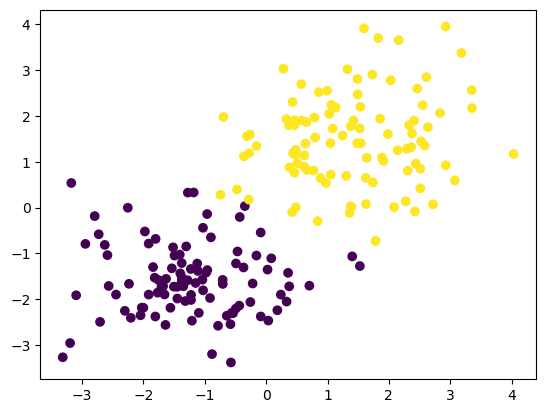

In [13]:
from scipy.optimize import curve_fit
import numpy as np

def linear_regression(x, w0, w1, w2):
    return x[:,0]*w0 + x[:,1]*w1 + w2

def logistic_regression(x, w0, w1, w2):
    lin_reg = linear_regression(x, w0, w1, w2)
    return 1 / (1 + np.exp(-lin_reg))

def generate_X_linear(N=200):
    """A little function that creates some data."""
    x = np.vstack([
        np.random.normal([-1.5, -1.5], 1, size=(int(N/2), 2)),
        np.random.normal([1.5, 1.5], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2))
    
    return x, y

# Generate input and output data
x, y = generate_X_linear()

params = curve_fit(logistic_regression, x, y)[0]
predictions = logistic_regression(x, params[0], params[1], params[2])
fig = plt.scatter(x[:, 0], x[:, 1], c=predictions)

We can see that after we fit the parameters for our logistic regression, it does a much better job at predicting whether or not a point is a 0 or a 1. Aside from a few ambiguous points in the middle, the predicted values of each point almost exactly match their actual values. The prediction scatter plot looks very similar to the scatter plot of actual values.

### Week 6

> **Ex. 6.1.3**: Another very famous type of synthetic network is the Barabási–Albert (BA) network.
1. Describe what a BA network is and how to create one.
2. On the [`NetworkX` documentations site](https://networkx.github.io/documentation/networkx-2.2/reference/generators.html), find a method you can use for generating a BA network. Create one with $N=100$ nodes and number of new edges from each new node $m=2$.
3. Plot the network
4. Visualize the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) of your newly created BA graph.
5. Explain the main difference(s) you observe, when comparing to the ER network.

1. A BA network is a network with a few nodes with lots of connections, refered to as hubs, which connect the many others nodes - these have much fewer connections than the hubs. To create small BA network, you could have three nodes which link to every node in the network, and then have 10 nodes which each have one connection to a hub and one other node.

In [14]:
#Question 2
import networkx as nx
from matplotlib import pyplot as plt
NetBA = nx.barabasi_albert_graph(100, 2)

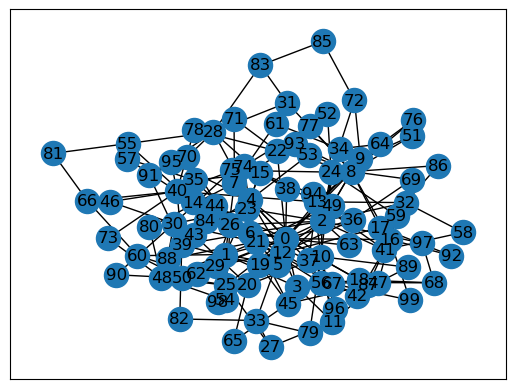

In [15]:
#Question 3
nx.draw_networkx(NetBA)

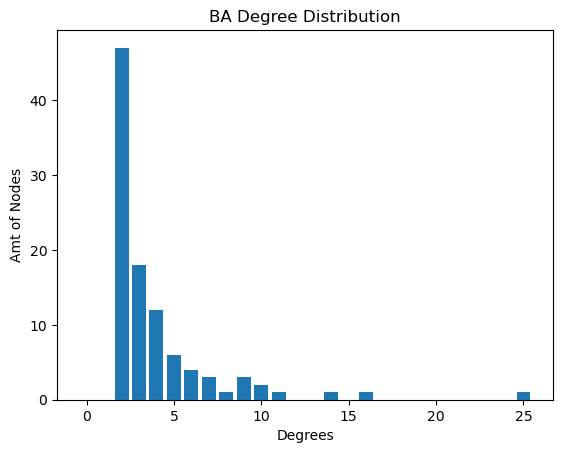

In [16]:
#Question 4
histogram = nx.degree_histogram(NetBA)

plt.bar(range(len(histogram)), histogram)
plt.xlabel("Degrees")
plt.ylabel("Amt of Nodes")
plt.title("BA Degree Distribution")
plt.show()

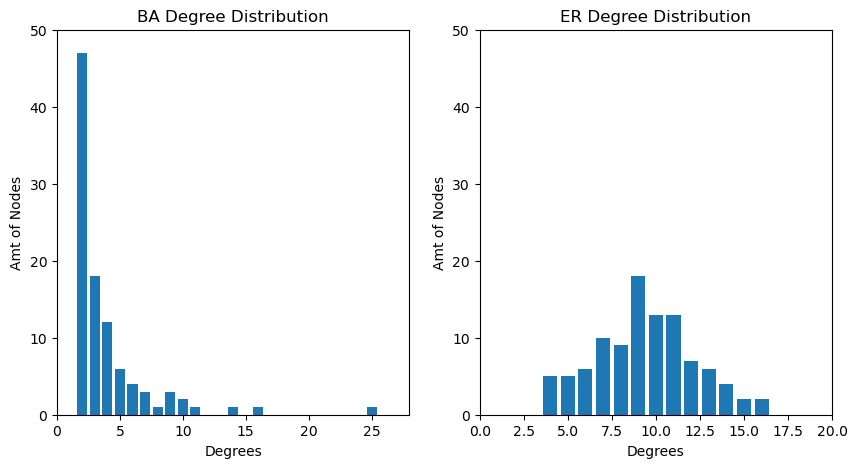

In [17]:
NetER = nx.fast_gnp_random_graph(100,0.1)
histogram2 = nx.degree_histogram(NetER)


fig, plot = plt.subplots(1, 2, figsize=(10, 5))

plot[0].bar(range(len(histogram)), histogram)
plot[0].set_xlabel("Degrees")
plot[0].set_ylabel("Amt of Nodes")
plot[0].set_title("BA Degree Distribution")
plot[0].set_xlim([0,28])
plot[0].set_ylim([0,50])


plot[1].bar(range(len(histogram2)), histogram2)
plot[1].set_xlabel("Degrees")
plot[1].set_ylabel("Amt of Nodes")
plot[1].set_title("ER Degree Distribution")
plot[1].set_xlim([0,20])
plot[1].set_ylim([0,50])

plt.show()

Question 5 

When comparing the ER degree distribution to the BA degree distribution we clearly see how our BA network has three hubs - these are the nodes with 19, 20, 26 connections. In addition to the hubs in our BA network, the reamining nodes have very few connections with the majority of nodes having less than 5 total connections. In contrast, the ER degree distribution looks almost normal without any clear outliers.

> **Ex: 6.2.2**: Create a `networkx.Graph` that represents each partnership between characters, as an edge. Print the number of nodes, edges and average degree of the resulting network.
**Do not** add characters that have no partners. And **do not** add links to partners of characters that are not in
your dataset.
>
> *Hint 1: You don't have to explicitly add nodes. Adding an edge will automatically add the corresponding nodes*<br>
> *Hint 2: As you know, many of the characters have a parenthesis in their name that is not important (like "Loki
(comics)"). If you remove this parenthesis your plots in the following will look much nicer. E.g. the regex code
`re.sub(" \(.+?\)", "", char)` will do the job of cleaning up a name like "Loki (comics)" for you. But then there's characters like "Captain America (William Burnside)"
where you might want to keep the parenthesis. It's not a hard requirement that you handle this in an elegant way,
just a suggestion for improving your analysis. In any event, ARGUE for what you do, even if that's doing nothing.*

In [18]:
import re, os

def get_partners(char, faction=None):
    """Return list of alliances for Marvel character."""
    if faction is None:
        for faction in ["heroes", "ambiguous", "villains"]:
            faction_chars = [c[:-4] for c in os.listdir("../data/%s" % faction)]
            if char in faction_chars:
                break
    # Load character markup
    with open("../data/%s/%s.txt" % (faction, char)) as fp:
        markup = fp.read()
        
    # Get partners field
    partners_field = re.findall(r"\| *partners[\w\W]+?(?=\|.+=|\}\})", markup)
    if partners_field == []:
        return []
 
    # Extract links from partners field
    return [t[2:-1] for t in re.findall(r"\[\[.+?[\]\|]", partners_field[0])]

get_partners("Iron Man (Ultimate Marvel character)")

['Ultimate Captain America', 'Ultimate Thor', 'War Machine']


nodes:           81
edges:           64
average degree:  1.5802469135802468



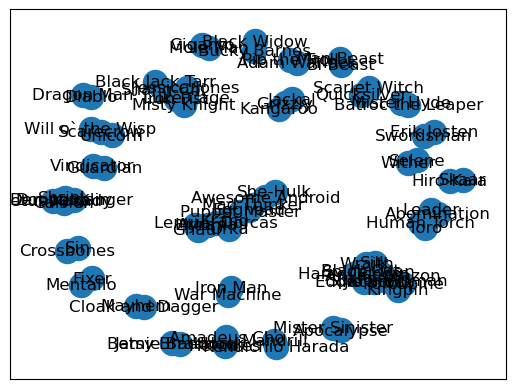

In [19]:
import networkx as nx
import pandas as pd
from numpy import average
G = nx.empty_graph()
#df = pd.read_csv('../outputs/marvel_characters.csv')

def clean_name(char):
    return re.sub(r" \(.+\)", "", char)

#make a set of every character
char_set = set()
for faction in ["heroes", "ambiguous", "villains"]:
    for char in os.listdir("../data/%s" % faction):
        if get_partners(char[:-4]): # only characters with partners get included in char_set
            char_set.add(char[:-4])
        
        
for char in char_set: # check that the character has partners (isn't lonely)
    for partner in get_partners(char): # check that the character's partners are in our dataset
        if partner in char_set:
            G.add_edge(clean_name(char), clean_name(partner))
    
nx.draw_networkx(G)
degs = [node[1] for node in G.degree()]
avg_deg = average(degs)
msg = f"""
nodes:           {len(G.nodes)}
edges:           {G.size()}
average degree:  {avg_deg}
"""
print(msg)

> **Ex: 6.2.3**: Plot the degree distribution of your character network. What type of random network (synthetic network) does it resemble?

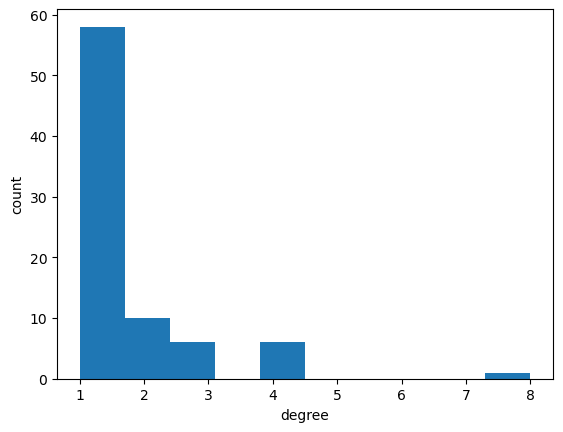

In [20]:
from matplotlib import pyplot as plt
plt.hist(degs)
plt.xlabel("degree")
plt.ylabel("count")
plt.show()

The above histogram resembles a BA network. It has few nodes with many connections and many nodes with few connections.